In [9]:
import tensorflow as tf
from tensorflow import keras
import numpy as np, cv2, matplotlib.pyplot as plt
model = keras.models.load_model('/content/digit.keras')

<IPython.core.display.Javascript object>

Predicted: 4 Confidence: 0.9999361038208008


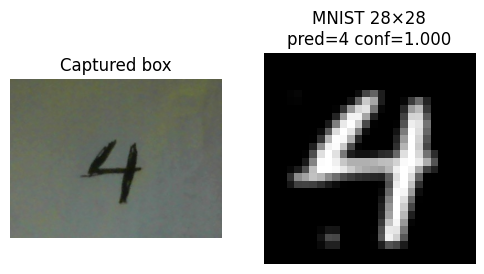

In [14]:

import numpy as np, cv2, matplotlib.pyplot as plt
from tensorflow import keras
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode


def take_guided_photo(quality=0.95, box_w_frac=0.6, box_h_frac=0.6):
    js = Javascript(r'''
      async function snap(quality, boxW, boxH) {
        const root = document.createElement('div');
        root.style.position = 'relative';

        const btn = document.createElement('button');
        btn.textContent = 'Capture';
        btn.style.margin = '8px 0';
        root.appendChild(btn);

        const video = document.createElement('video');
        video.style.display = 'block';
        root.appendChild(video);

        const overlay = document.createElement('canvas');
        overlay.style.position = 'absolute';
        overlay.style.left = '0';
        overlay.style.top = '0';
        overlay.style.pointerEvents = 'none';
        root.appendChild(overlay);

        const stream = await navigator.mediaDevices.getUserMedia({video:true});
        document.body.appendChild(root);
        video.srcObject = stream;
        await video.play();

        const vw = () => video.videoWidth, vh = () => video.videoHeight;

        const full = document.createElement('canvas');
        const fctx = full.getContext('2d');
        const crop = document.createElement('canvas');
        const cctx = crop.getContext('2d');


        let raf;
        function drawOverlay(){
          if (vw()===0 || vh()===0) { raf=requestAnimationFrame(drawOverlay); return; }
          overlay.width = vw(); overlay.height = vh();
          const o = overlay.getContext('2d');
          o.clearRect(0,0,overlay.width,overlay.height);
          const bw = Math.round(vw()*boxW);
          const bh = Math.round(vh()*boxH);
          const bx = Math.round((vw()-bw)/2);
          const by = Math.round((vh()-bh)/2);
          o.fillStyle = 'rgba(0,0,0,0.35)'; o.fillRect(0,0,overlay.width,overlay.height);
          o.clearRect(bx,by,bw,bh);
          o.strokeStyle = '#00FF99'; o.lineWidth = 4; o.strokeRect(bx,by,bw,bh);
          raf=requestAnimationFrame(drawOverlay);
        }
        drawOverlay();

        // wait for click
        await new Promise(resolve => btn.onclick = resolve);

        // capture and crop
        full.width = vw(); full.height = vh();
        fctx.drawImage(video, 0, 0);
        const bw = Math.round(vw()*boxW);
        const bh = Math.round(vh()*boxH);
        const bx = Math.round((vw()-bw)/2);
        const by = Math.round((vh()-bh)/2);
        crop.width = bw; crop.height = bh;
        cctx.drawImage(video, bx, by, bw, bh, 0, 0, bw, bh);
        const dataUrl = crop.toDataURL('image/jpeg', quality);

        cancelAnimationFrame(raf);
        stream.getVideoTracks()[0].stop();
        root.remove();
        return dataUrl;
      }
    ''')
    display(js)
    data_url = eval_js(f'snap({quality}, {box_w_frac}, {box_h_frac})')
    b = b64decode(data_url.split(',')[1])
    arr = np.frombuffer(b, np.uint8)
    img = cv2.imdecode(arr, cv2.IMREAD_COLOR)  # BGR crop of the box
    if img is None: raise RuntimeError("Capture failed")
    return img


def mnist_like_boxonly(box_bgr):
    g = cv2.cvtColor(box_bgr, cv2.COLOR_BGR2GRAY)
    H,W = g.shape
    pad = int(0.10*min(H,W))
    g = g[pad:H-pad, pad:W-pad]  # trim border
    if g.size == 0: return None, None

    bg = cv2.GaussianBlur(g,(0,0),21)
    norm = cv2.normalize(g-bg,None,0,255,cv2.NORM_MINMAX)

    th1 = cv2.adaptiveThreshold(norm,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY,31,5)
    _, th2 = cv2.threshold(cv2.GaussianBlur(norm,(5,5),0),0,255,
                           cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    th = th1 if (th1==255).sum() < (th2==255).sum()*1.2 else th2
    if th.mean()>127: th = 255-th

    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, np.ones((3,3),np.uint8))
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, np.ones((3,3),np.uint8))

    cnts,_ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts: return None, None
    A=th.shape[0]*th.shape[1]; cx,cy=W/2,H/2
    best=None; score_best=-1e18
    for c in cnts:
        x,y,w,h=cv2.boundingRect(c); area=w*h
        if area<0.002*A or area>0.25*A: continue
        ar=w/max(h,1)
        if not (0.4<=ar<=2.5): continue
        mx,my=x+w/2,y+h/2; d2=(mx-cx)**2+(my-cy)**2
        score=(area/A)-0.002*d2
        if score>score_best: score_best=score; best=(x,y,w,h)
    if best is None: return None, None
    x,y,w,h=best; roi=th[y:y+h,x:x+w]

    if h>w: new_h,new_w=20,int(round(w*20/h))
    else:   new_w,new_h=20,int(round(h*20/w))
    small=cv2.resize(roi,(new_w,new_h),interpolation=cv2.INTER_AREA)
    top=(28-new_h)//2; bottom=28-new_h-top
    left=(28-new_w)//2; right=28-new_w-left
    canvas=cv2.copyMakeBorder(small,top,bottom,left,right,cv2.BORDER_CONSTANT,value=0)

    ys,xs=np.nonzero(canvas)
    if len(xs) and len(ys):
        cxo,cyo=xs.mean(),ys.mean()
        M=np.float32([[1,0,14-cxo],[0,1,14-cyo]])
        canvas=cv2.warpAffine(canvas,M,(28,28),borderValue=0)

    x28=(canvas.astype("float32")/255.0)[None,...,None]  # (1,28,28,1)
    return x28, canvas


crop = take_guided_photo(quality=0.95, box_w_frac=0.6, box_h_frac=0.6)
x, vis = mnist_like_boxonly(crop)
if x is None:
    raise RuntimeError("No digit found in the guided box.")

probs = model.predict(x, verbose=0)[0]
pred, conf = int(np.argmax(probs)), float(np.max(probs))
print("Predicted:", pred, "Confidence:", conf)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)); plt.title("Captured box"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(vis, cmap='gray'); plt.title(f"MNIST 28×28\npred={pred} conf={conf:.3f}"); plt.axis("off")
plt.show()
